In [1]:
%matplotlib widget
#%matplotlib inline


In [2]:
import numpy as np
import pandas as pd
import aseg_gdf2
from shapely.geometry import Point, LineString, MultiPoint, Polygon
from shapely.wkt import loads
from scipy.io import loadmat
from scipy import spatial
import matplotlib.pyplot as plt
import rasterio
import netCDF4
import h5py
import gc
import os
import glob
from scipy.spatial.ckdtree import cKDTree
from hydrogeol_utils import SNMR_utils, spatial_functions, AEM_utils
from hydrogeol_utils import plotting_utils as plot_utils
import string

In [3]:
def nearest_neighbours(points, coords, points_required = 1, max_distance = 250.):
    """

    :param points: array of points to find the nearest neighbour for
    :param coords: coordinates of points
    :param points_required: number of points to return
    :param max_distance: maximum search radius
    :return:
    """
    # Initialise tree instance
    kdtree = cKDTree(data=coords)

    # iterate throught the points and find the nearest neighbour
    distances, indices = kdtree.query(points, k=points_required,
                                      distance_upper_bound=max_distance)
    print(distances)
    # Mask out infitnite distances in indices to avoid confusion
    mask = ~np.isfinite(distances)

    distances[mask] = np.nan

    return distances, indices

# Find the nearest neighbours within the maximum distance

def xy_2_var(grid_dict, xy, var):
    """
    Function for finding a variable for gridded AEM sections
    given an input easting and northing
    @ param: grid_dict :dictionary for gridded line data
    @ param: xy: numpy array with easting and northing
    @ param: var: string with variable name
    returns
    float: distance along line
    """
    utm_coords = np.column_stack((grid_dict['easting'],
                                  grid_dict['northing']))

    d, i = spatial_functions.nearest_neighbours(xy,
                                                utm_coords,
                                                points_required=1,
                                                max_distance=100.)
    if np.isnan(d[0]):
        return None

    else:
        near_ind = i[0]
    


        return grid_dict[var][near_ind]

def in_bounds(coords, b):
    """
    Function return true if point is within raster bounds
    coords = 1d numpy array (x,y)
    b = raseter dataset bounds from rasterio
    """
    x,y = coords[0], coords[1]
    
    if np.all([x > b.left, x < b.right,
                     y > b.bottom, y < b.top]):
        return True
    else:
        return False

In [4]:
infile = r"C:\Users\PCUser\Desktop\AEM\LCI\DalyR_WB_MGA52.nc"

lci_dat = netCDF4.Dataset(infile)

lci_coords = np.column_stack((lci_dat['easting'][:],
                          lci_dat['northing'][:]))

# Initialise tree instance for nearest neighbour searches
kdtree = cKDTree(data=lci_coords)


# bring in the rjmcmc data

infile = r"C:\Users\PCUser\Desktop\AEM\rjmcmc\DalyRiver_rjmcmc.nc"

# Read in the data

rj_dat = netCDF4.Dataset(infile)



In [5]:
# Since we will be wanting to plot the sections lets first grid them

# Create an instance of plots for gridding the data

plots = plot_utils.ConductivitySectionPlot(lci_dat)


# Define some key variables which we want to inteprolate

cond_vars = ['conductivity', 'data_residual', 'depth_of_investigation']

plots.conductivity_variables = cond_vars


# Define the resolution of th sections
xres, yres = 10., 2.


In [6]:
# We will use the lines from the rj

lines = rj_dat['line'][:]

# Now grid the lines and save in memory

hdf5_dir = r"C:\Users\PCUser\Desktop\NSC_data\data\AEM\DR\lci\hdf5"

if not os.path.exists(hdf5_dir):
    os.mkdir(hdf5_dir)

gridded_vars ={}

# Saved these out to save time

#gridded_vars = plots.grid_variables(xres = xres, yres =yres, lines=lines,
#                                    resampling_method = 'cubic', save_hdf5 = True,
 #                                   return_dict = True, hdf5_dir = hdf5_dir)

for line in lines:
    
    infile = os.path.join(hdf5_dir, str(line) + '.hdf5')
    f = h5py.File(infile, 'r')
    gridded_vars[line] = plot_utils.extract_hdf5_data(f, cond_vars)
    f = None
    gc.collect()

In [7]:
# Now we bring in the Oolloo Jinduckin contact to plot

#inRaster = r"C:\Users\PCUser\Desktop\NSC_data\data\raster\Daly_Aquifers\export\topOolloo_BOM.tif"
#inRaster = r"C:\Users\PCUser\Desktop\NSC_data\data\raster\Daly_Aquifers\export\tJind_BOM.tif"
inRaster = r"C:\Users\PCUser\Desktop\NSC_data\data\raster\Daly_Aquifers\LeapFrog_export\OllooJind_contact.grd"


contact_dataset = rasterio.open(inRaster)

contact_elev = contact_dataset.read(1)

contact_elev[contact_elev == contact_dataset.get_nodatavals()] = np.nan


In [8]:
line

912005

In [9]:

for line in gridded_vars.keys():
    
    # Get the coordinates
    utm_coords = np.column_stack((gridded_vars[line]['easting'],
                                  gridded_vars[line]['northing']))
    
    elevGen = contact_dataset.sample(utm_coords)

    new_var = 'topJind_elev'
    #new_var = 'base_Florina_elev'
    
    gridded_vars[line][new_var] = np.nan*np.ones(shape = utm_coords.shape[0],
                                                 dtype = np.float)
    
    for i in range(utm_coords.shape[0]):
            
        if not in_bounds(utm_coords[i], contact_dataset.bounds):
                
            pass
            
        else:
                
            surfaceElev = next(contact_dataset.sample([utm_coords[i]]))[0]
                
            # If the values of the surface is not a null
            if not np.isclose(surfaceElev,
                              contact_dataset.get_nodatavals()[0]):
                if surfaceElev < gridded_vars[line]['elevation'][i]:
                    
                    gridded_vars[line][new_var][i] = surfaceElev

In [10]:
# Now we bring in the magnetics to plot

inRaster = r"C:\Users\PCUser\Desktop\NSC_data\data\AEM\DR\2017_DalyRiver_SkyTEM\03_LCI\03_Depth_Slices\Grids_doi_Masked\*.ers"

cond = {}

for file in glob.glob(inRaster):
    layer = int(file.split('Con')[1].split('_')[0])
    cond_dataset = rasterio.open(file)
    cond[layer] = cond_dataset.read(1)



In [18]:
# Bring in a subset of the points to sample

infile = r"C:\Users\PCUser\Desktop\NSC_data\data\AEM\DR\garjmcmctdem_2\combined\rjmcmc_map.csv"

df = pd.read_csv(infile)



In [19]:
# generator for sampling the bom raster
contElev = contact_dataset.sample(df[['easting ', 'northing ']].values)

# Add the distance along the gridded lines to the dataframe

df['dist_along_line'] = np.nan

df['point_ind_rj'] = -9999

df['point_ind_lci'] = -9999

df['baseJind_depth'] = np.nan

for index, row in df.iterrows():

    # get the line and coordinates
    line = row['line ']
    
    xy = np.array([row[['easting ','northing ']].values])
    
    df.loc[index,'dist_along_line'] = xy_2_var(gridded_vars[line],
                                               xy,'grid_distances')
    
    df.loc[index,'point_ind_rj'] = np.where(rj_dat['fiducial'][:]== row['fiducial '])[0][0]
    
    df.loc[index,'point_ind_lci'] = kdtree.query(row[['easting ', 'northing ']].values)[1]
    
    nElev = next(contElev)[0]
    
    if not np.isclose(nElev,contact_dataset.get_nodatavals()[0]):
        
        df.loc[index, 'baseJind_depth'] = row['elevation '] - nElev

In [20]:
df.columns

Index(['uniqueid ', 'survey ', 'date ', 'flight ', 'line ', 'fiducial ',
       'easting ', 'northing ', 'elevation ', 'altimeter ', 'nchains ',
       'nsamples ', 'nburnin ', 'sampletime ', 'misfit_lowest ',
       'misfit_average ', 'ndepthcells ', 'geom', 'matfile', 'dist_along_line',
       'point_ind_rj', 'point_ind_lci', 'baseJind_depth'],
      dtype='object')

In [21]:
# Since we only want to find points that fall within the extent of the Jinduckin
# we apply a spatial mask


# bring in a shapefile as a geometry

infile = r"C:\Users\PCUser\Desktop\NSC_data\data\vector\DalyRiver\DalyGeology_August2018.shp"

from osgeo import ogr
file = ogr.Open(infile)
shape = file.GetLayer(0)
#first feature of the shapefile
feature = shape.GetFeature(3)

#feature = shape.GetFeature(11)

import json
shapefile = json.loads(feature.ExportToJson())

Florina_extent = Polygon(shapefile['geometry']['coordinates'][0])

from functools import partial
import pyproj
from shapely.ops import transform

project = partial(
    pyproj.transform,
    pyproj.Proj(init='epsg:4283'), # source coordinate system
    pyproj.Proj(init='epsg:28352')) # destination coordinate system

JindExtent = transform(project, Florina_extent)  # apply projection

JindExtent = JindExtent.buffer(100.)


#Iterate through an get the indices of those that fall within the Oolloo

idx = []

for index, row in df.iterrows():
    coords = row[['easting ', 'northing ']].values
    
    if JindExtent.contains(Point(coords)):
        idx.append(index)
        
mask = df.index.isin(idx)

df_ss = df.copy()#[mask]

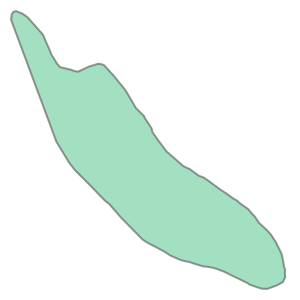

In [22]:
JindExtent

In [23]:
df_ss.sort_values(by = 'easting ', inplace = True)

In [24]:
df_ss['basejinduckin_interp'] = np.nan

In [25]:
df_ss

,uniqueid,survey,date,flight,line,fiducial,easting,northing,elevation,altimeter,...,misfit_lowest,misfit_average,ndepthcells,geom,matfile,dist_along_line,point_ind_rj,point_ind_lci,baseJind_depth,basejinduckin_interp
710,12370,1304,20170817,20170817,105601,1398029.0,706217.2,8421701.0,154.04,0,...,212.556700,212.843300,250,POINT (706217.2 8421701),C:\Users\PCUser\Desktop\NSC_data\data\AEM\DR\g...,NaN,710,50402,NaN,NaN
1351,12350,1304,20170817,20170817,105601,1398019.0,706474.6,8421696.0,213.95,0,...,1574.270000,1576.173000,250,POINT (706474.6 8421696),C:\Users\PCUser\Desktop\NSC_data\data\AEM\DR\g...,NaN,1351,50402,NaN,NaN
154,12330,1304,20170817,20170817,105601,1398009.0,706729.8,8421693.0,206.20,0,...,833.794700,834.709500,250,POINT (706729.8 8421693),C:\Users\PCUser\Desktop\NSC_data\data\AEM\DR\g...,NaN,154,50402,NaN,NaN
1906,12310,1304,20170817,20170817,105601,1397999.0,706989.1,8421687.0,186.19,0,...,481.674500,482.147400,250,POINT (706989.1 8421687),C:\Users\PCUser\Desktop\NSC_data\data\AEM\DR\g...,NaN,1906,50402,NaN,NaN
709,12290,1304,20170817,20170817,105601,1397989.0,707239.1,8421684.0,172.39,0,...,469.906000,470.255700,250,POINT (707239.1 8421684),C:\Users\PCUser\Desktop\NSC_data\data\AEM\DR\g...,NaN,709,50402,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1004,35890,1304,20170819,20170819,109701,1582725.5,866631.6,8395128.0,145.06,0,...,2.287993,2.784706,250,POINT (866631.6 8395128),C:\Users\PCUser\Desktop\NSC_data\data\AEM\DR\g...,64360.0,1004,96445,NaN,NaN
2201,35910,1304,20170819,20170819,109701,1582735.5,866751.2,8395364.0,145.57,0,...,45.790980,46.708880,250,POINT (866751.2 8395364),C:\Users\PCUser\Desktop\NSC_data\data\AEM\DR\g...,64640.0,2201,96455,NaN,NaN
449,35930,1304,20170819,20170819,109701,1582745.5,866873.8,8395610.0,143.24,0,...,10.843350,11.185910,250,POINT (866873.8 8395610),C:\Users\PCUser\Desktop\NSC_data\data\AEM\DR\g...,64900.0,449,96465,NaN,NaN
1646,35950,1304,20170819,20170819,109701,1582755.5,867012.1,8395826.0,140.35,0,...,16.208310,17.154870,250,POINT (867012.1 8395826),C:\Users\PCUser\Desktop\NSC_data\data\AEM\DR\g...,65160.0,1646,96475,NaN,NaN


In [26]:
# This function stores the top of the conductor in the dataframe on a click
def onclick(event):
    if event.xdata != None and event.ydata != None:
        df_ss.at[ind, 'basejinduckin_interp'] = event.ydata


def extract_data():
    """
    FUnction for extracting all the AEM data from the netCDF files
    """

    freq = rj_dat['conductivity_bin_count'][point_ind_rj].data.astype(np.float)

    cond_pdf = freq / freq.sum(axis =1)[0]

    cond_pdf[cond_pdf == 0] = np.nan
    
    cp_freq = rj_dat['change_point'][point_ind_rj].data.astype(np.float)
    
    cp_pdf = cp_freq / freq.sum(axis =1)[0]
    
    laybins = rj_dat['nlayer_bin_count'][point_ind_rj].data
    
    lay_prob = laybins / freq.sum(axis =1)[0]
    
    cond_cells = rj_dat["conductivity_cells"][:].data
    
    depth_cells = rj_dat['layer_top_depth'][point_ind_rj].data
    
    extent = [cond_cells.min(), cond_cells.max(), depth_cells.max(), depth_cells.min()]
    
    mean = rj_dat['conductivity_mean'][point_ind_rj].data
    p10 = rj_dat['conductivity_p10'][point_ind_rj].data
    p50 = rj_dat['conductivity_p50'][point_ind_rj].data
    p90 = rj_dat['conductivity_p90'][point_ind_rj].data
    
    lci_cond = lci_dat['conductivity'][point_ind_lci].data
    lci_depth_top = lci_dat['layer_top_depth'][point_ind_lci].data
    
    lci_doi = lci_dat['depth_of_investigation'][point_ind_lci].data
    
    misfit = rj_dat['misfit'][point_ind_rj].data
    sample_no = rj_dat['rj_sample_number'][:].data
    
    burnin = rj_dat["nburnin"][point_ind_rj].data
    nsamples = rj_dat['nsamples'][point_ind_rj].data
    nchains = rj_dat['nchains'][point_ind_rj].data
    
    line_ind = rj_dat['line_index'][point_ind_rj].data
    line = int(rj_dat['line'][line_ind].data)
    
    return {'conductivity_pdf': cond_pdf, "change_point_pdf": cp_pdf, "conductivity_extent": extent,
           'cond_p10': p10, 'cond_p50': p50, 'cond_p90': p90, 'cond_mean': mean, 'depth_cells': depth_cells,
           'nlayer_bins': laybins, 'nlayer_prob': lay_prob, 'nsamples': nsamples, 'ndata': rj_dat['n_data'][:].data,
           "nchains": nchains, 'burnin': burnin, 'misfit': misfit, 'sample_no': sample_no, 'cond_cells': cond_cells, 'lci_cond': lci_cond,
           'lci_depth_top': lci_depth_top, 'lci_doi': lci_doi, 'line': line}
    
def DR_plot(D, outfile = None):
    fig = plt.figure(figsize = (12,10))

    # These are for interactive widget mode
    fig.canvas.layout.width = '6in'
    fig.canvas.layout.height= '5in'

    ax1 = fig.add_axes([0.05, 0.35, 0.35, 0.62])
    ax2 = fig.add_axes([0.45, 0.35, 0.2, 0.62])
    ax3 = fig.add_axes([0.70, 0.52, 0.2, 0.2])
    ax4 = fig.add_axes([0.72, 0.32, 0.16, 0.16])
    ax5 = fig.add_axes([0.1, 0.18, 0.76, 0.05])
    ax6 = fig.add_axes([0.1, 0.05, 0.76, 0.13])
    ax7 = fig.add_axes([0.70, 0.78, 0.2, 0.2])
    cbar_ax1 = fig.add_axes([0.05, 0.29, 0.35, 0.01])
    cbar_ax2 = fig.add_axes([0.88, 0.05, 0.01, 0.2])
    
    panel_kwargs = [{'title': '',
                      'color': 'black',
                      'ylabel': 'data \n residual',
                      'legend': False},
                     {'title': 'LCI conductivity',
                      'max_depth': 400.,
                      'shade_doi': True,
                      'colourbar': True,
                      'colourbar_label': 'Conductivity (S/m)',
                      'log_plot': True,
                      'vmin': 0.001,
                      'vmax': 2.,
                      'cmap': 'jet',
                      'ylabel': 'elevation \n (mAHD)',
                      'vertical_exaggeration': 1.0}]


    # Plot probability map
    
    im = ax1.imshow(D['conductivity_pdf'], extent = D['conductivity_extent'],
                    aspect = 'auto', cmap = 'rainbow')
    
    #  PLot the median, and percentile plots
    ax1.plot(np.log10(D['cond_p10']), D['depth_cells'], c = 'k',linestyle='dashed', label = 'p10')
    ax1.plot(np.log10(D['cond_p90']), D['depth_cells'], c = 'k',linestyle='dashed', label = 'p90')
    ax1.plot(np.log10(D['cond_p50']), D['depth_cells'], c = 'k',label = 'p50')
    ax1.plot(np.log10(D['cond_mean']), D['depth_cells'], c = 'grey',label = 'mean')
    
    ax1.set_xticklabels([round(10 ** float(x), 4) for x in ax1.get_xticks()])

    # for lci layered model we do some processing
    lci_expanded = np.zeros(shape=2 * len(D['lci_cond']) + 1,
                                 dtype=np.float)

    lci_expanded[1:] = np.repeat(D['lci_cond'], 2)

    depth_expanded = (np.max(D['lci_depth_top']) + 10) * np.ones(shape=len(lci_expanded),
                                                            dtype=np.float)

    depth_expanded[:-1] = np.repeat(D['lci_depth_top'], 2)

    ax1.plot(np.log10(lci_expanded), depth_expanded, c = 'pink',
             linestyle = 'dashed', label = 'lci')
    ax1.plot(ax1.get_xlim(), [D['lci_doi'], D['lci_doi']], c = 'yellow',
             label = 'LCI doi')
    ax1.set_title('rj-MCMC probability map')
    ax1.set_ylabel('depth (mBGL)')
    ax1.set_xlabel('Conductivity (S/m)')
    ax1.grid(which = 'both')
    ax1.set_xlim(D['conductivity_extent'][0], D['conductivity_extent'][1] )
    
    ax1.set_ylim(D['conductivity_extent'][2], D['conductivity_extent'][3])#100.,0)#
    
    
    #ax1.plot(ax1.get_xlim(), [row['baseJind_depth'], row['baseJind_depth']],
    #        c = 'green', linewidth = 2, label = 'top Jinduckin - DENR2018')
        
    ax1.legend(loc = 3)
    ax2.plot(D['change_point_pdf'], D['depth_cells'], label = 'P(change point)')
    ax2.set_ylim(ax2.get_ylim()[::-1])
    ax2.set_yticks(np.arange(0, 500, 20.))
    ax2.set_title('change point probability')
    ax2.set_ylim(D['conductivity_extent'][2], D['conductivity_extent'][3])#(100.,0)
    #ax2.plot(ax2.get_xlim(), [row['baseJind_depth'], row['baseJind_depth']],
    #        c = 'green', linewidth = 2, label = 'top Jinduckin - DENR2018')
    ax2.legend()
    ax2.grid(which = 'both')
    
    
    

    ax3.imshow(contact_elev, 
               extent = [contact_dataset.bounds[0], contact_dataset.bounds[2],
                         contact_dataset.bounds[1], contact_dataset.bounds[3]],
              cmap= 'viridis')#, vmin = -2., vmax = 2.)
    ax3.set_xlim(D['easting'] - 40000., D['easting'] + 40000.)
    ax3.set_ylim(D['northing'] - 40000., D['northing'] + 40000.)
    ax3.plot(D['easting'],D['northing'], 'x', c = 'r')
    ax3.set_title('Jinduckin-Oolloo contact', fontsize=10)
    #ax3.set_title("Top Oolloo")
    ax3.tick_params(axis='both', which='major', labelsize=8)
    ax3.tick_params(axis='both', which='minor', labelsize=8)
    # Ax3 will be our location
    sample = D['sample_no'][:]
    
    # Add the misfit
    for i in range(D['misfit'].shape[0]):
       
        misfits = D['misfit'][i]
        ax4.plot(sample, misfits/D['ndata'])

    ax4.plot([1, D['nsamples']], [1,1], 'k')
    ax4.plot([D['burnin'], D['burnin']],[0.1,1e4], 'k')
    ax4.set_xlim([1, D['nsamples']])
    ax4.set_ylim(0.1, 1e4)

    ax4.set_xscale('log')
    ax4.set_yscale('log')

    ax4.set_xlabel("sample #")
    ax4.set_ylabel("Normalised misfit")
    
    # conductivity plot
    
    ax7.imshow(np.log10(cond[9]), extent = [cond_dataset.bounds[0],
                                  cond_dataset.bounds[2],
                                  cond_dataset.bounds[1], 
                                  cond_dataset.bounds[3]],
              cmap = 'jet',
              vmin = np.log10(panel_kwargs[1]['vmin']*1000.),
              vmax = np.log10(panel_kwargs[1]['vmax']*1000.))
    
    ax7.set_xlim(D['easting'] - 10000., D['easting'] + 10000.)
    ax7.set_ylim(D['northing'] - 10000., D['northing'] + 10000.)
    ax7.plot(D['easting'],D['northing'],  'x', c = 'k')
    
    p1 = [gridded_vars[line]['easting'][0], gridded_vars[line]['easting'][-1]]
    p2 = [gridded_vars[line]['northing'][0], gridded_vars[line]['northing'][-1]]
    ax7.plot(p1, p2, 'k', linewidth = 0.5)
    ax7.set_title('LCI depth slice 61.8-71.6 mBGL', fontsize=10)
    ax7.tick_params(axis='both', which='major', labelsize=8)
    ax7.tick_params(axis='both', which='minor', labelsize=8)
    cb1 = fig.colorbar(im, cax=cbar_ax1, orientation='horizontal')
    cb1.set_label('probabilitiy', fontsize=10)

    res1 = plot_utils.plot_single_line(ax5, gridded_vars[line],
                                       'data_residual', panel_kwargs[0])

    ax5.set_title('LCI conductivity section - ' + str(line))

    im2 = plot_utils.plot_grid(ax6, gridded_vars[line], 'conductivity',
                               panel_kwargs[1])
    
    # PLot jinduckin elevation onto section
    ax6.plot(gridded_vars[line]['grid_distances'],
            gridded_vars[line]['topJind_elev'], c = 'k',
            linestyle = 'dashed')
    
    # Add colorbars

    ax6.plot([dist, dist], [-500, 500], 'pink')
    ax6.set_xlabel("Distance along line (m)")
    
        
    cb2 = fig.colorbar(im2, cax=cbar_ax2, orientation='vertical')
    
    cb2.ax.set_yticklabels([round(10 ** x, 4) for x in cb2.get_ticks()])
    cb2.set_label('conductivity (S/m)', fontsize=10)
    
    ax5.set_xlim(dist - 5000.,
                 dist + 5000.)
    ax6.set_xlim(dist - 5000., 
                 dist + 5000.)

    ax_array = np.array([ax1, ax2, ax3, ax4, ax5, ax6, ax7])
    
    return fig, ax_array   

In [34]:
np.min(np.abs(df_ss['fiducial '].values - 1056640.5))

0.0

In [35]:
np.max(df_ss['fiducial '] == 1056640.5)


True

In [36]:
fids = np.array([1056640.5,
1143674,
1056620.5,
1056660.5,
1143694,
1126381.5,
1053326,
1053564.5,
1053536,
1053493.5,
1054737,
1143678.5,
1057905,
1057907.5,
1918444.5,
1389084,
1140233,
1054701,
1053406.5,
1053326,
1056646.5,
1140220,
1053412.5,
1053311.5,
1056652.5,
1056630.5,
1056650.5,
1143684,
1056630.5,
1143664
])

fids


array([1056640.5, 1143674. , 1056620.5, 1056660.5, 1143694. , 1126381.5,
       1053326. , 1053564.5, 1053536. , 1053493.5, 1054737. , 1143678.5,
       1057905. , 1057907.5, 1918444.5, 1389084. , 1140233. , 1054701. ,
       1053406.5, 1053326. , 1056646.5, 1140220. , 1053412.5, 1053311.5,
       1056652.5, 1056630.5, 1056650.5, 1143684. , 1056630.5, 1143664. ])

In [16]:
# Create a generator to iterate through the pandas dataframe

def gen(df):
    for index, row in df.iterrows():
        yield index, row
        
row


uniqueid                                                       44470
survey                                                          1304
date                                                        20170823
flight                                                      20170823
line                                                          109204
fiducial                                                 1.91663e+06
easting                                                       864633
northing                                                 8.39366e+06
elevation                                                     133.95
altimeter                                                          0
nchains                                                           32
nsamples                                                      100000
nburnin                                                        50000
sampletime                                                   16283.4
misfit_lowest                     

In [38]:
line = 109201

n = 5

df_line = df_ss[df_ss['line '] == line]

print(len(df_line))


print(len(df_line.iloc[::n,:]))

cond_gen = gen(df_line.iloc[::n,:])
#cond_gen = gen(df_line.iloc[-2:-1,:])

320
64


In [39]:
# Define some coordinates to investigate

fid = 1477169

cond_gen = gen(df_ss[df['fiducial '] == fid])


ind, row = next(cond_gen)

point_ind_lci = row['point_ind_lci']

point_ind_rj = row['point_ind_rj']

# Get the nearest lci point

easting, northing = row['easting '], row['northing ']


plt.close('all')

D = extract_data()

D['easting'], D['northing'] = easting, northing


line = row['line ']

# Find distance along the lci section
dist = xy_2_var(gridded_vars[line],
                 np.array([[easting, northing]]),
                         'grid_distances')


point_ind_lci= dist
print(easting)
print(northing)

fig, ax_array = DR_plot(D)
#plt.savefig(r"C:\Users\PCUser\Desktop\NSC_data\DR_interp\rjplots\\Florina_" + row['BORE_NO'] + ".png", dpi = 150)
#cid=  fig.canvas.mpl_connect('button_press_event', onclick)

#ax_array[4].set_xlim(0,6000.)
#ax_array[5].set_xlim(0,6000.)

ax_array[0].plot(ax_array[0].get_xlim(), [304,304.], c = 'red',
                label = 'Geoscience Australia \ninterpretation')

ax_array[1].plot(ax_array[1].get_xlim(), [304,304.], c = 'red',
                label = 'Geoscience Australia \ninterpretation')
ax_array[0].legend(loc = 'lower left')
ax_array[1].legend(loc = 'lower left')

ax_array[1].set_xlim([0,0.5])



ax_array[0].text(0.02, 0.93, 'A', transform=ax_array[0].transAxes, 
            size=30, bbox=dict(facecolor='white', alpha=0.8))
ax_array[1].text(0.84, 0.93, 'B', transform=ax_array[1].transAxes, 
            size=30, bbox=dict(facecolor='white', alpha=0.8))
ax_array[2].text(0.8, 0.8, 'D', transform=ax_array[2].transAxes, 
            size=30, bbox=dict(facecolor='white', alpha=0.8))
ax_array[3].text(0.82, 0.75, 'E', transform=ax_array[3].transAxes, 
            size=30, bbox=dict(facecolor='white', alpha=0.8))
ax_array[4].text(0.01, 0.25, 'F', transform=ax_array[4].transAxes, 
            size=30)
ax_array[6].text(0.8, 0.8, 'C', transform=ax_array[6].transAxes, 
            size=30, bbox=dict(facecolor='white', alpha=0.8))
#df_ss.to_csv(r"C:\temp\justincase.csv", index = False)
plt.savefig(r"C:\Users\PCUser\Desktop\NSC_data\reporting\Daly\Figures\fig4.png",
           dpi = 200)


plt.show()


791771.8
8414145.0


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

C:\Users\PCUser\Anaconda3\envs\hydrogeol_utils\lib\site-packages\ipykernel_launcher.py:116: RuntimeWarning: divide by zero encountered in log10
C:\Users\PCUser\Anaconda3\envs\hydrogeol_utils\lib\site-packages\ipykernel_launcher.py:179: RuntimeWarning: invalid value encountered in log10


In [27]:
# Define some coordinates to investigate

fid = 1126381.5

cond_gen = gen(df_ss[df['fiducial '] == fid])


ind, row = next(cond_gen)

point_ind_lci = row['point_ind_lci']

point_ind_rj = row['point_ind_rj']

# Get the nearest lci point

easting, northing = row['easting '], row['northing ']


plt.close('all')

D = extract_data()

D['easting'], D['northing'] = easting, northing



line = row['line ']

# Find distance along the lci section
dist = xy_2_var(gridded_vars[line],
                 np.array([[easting, northing]]),
                         'grid_distances')


point_ind_lci= dist
print(easting)
print(northing)

fig, ax_array = DR_plot(D)
#plt.savefig(r"C:\Users\PCUser\Desktop\NSC_data\DR_interp\rjplots\\Florina_" + row['BORE_NO'] + ".png", dpi = 150)
#cid=  fig.canvas.mpl_connect('button_press_event', onclick)

ax_array[4].set_xlim(0,6000.)
ax_array[5].set_xlim(0,6000.)

ax_array[0].plot(ax_array[0].get_xlim(), [201,201.], c = 'red',
                label = 'Geoscience Australia \ninterpretation')

ax_array[1].plot(ax_array[1].get_xlim(), [201,201.], c = 'red',
                label = 'Geoscience Australia \ninterpretation')


ax_array[0].plot(ax_array[0].get_xlim(), [199,199],
             c = 'green', linewidth = 2, label = 'top Jinduckin - RN006825')

ax_array[1].plot(ax_array[0].get_xlim(), [199,199],
             c = 'green', linewidth = 2, label = 'top Jinduckin - RN006825')

ax_array[0].legend()
ax_array[1].legend(loc = 'lower left')
ax_array[1].set_xlim([0,0.29])



ax_array[0].text(0.02, 0.93, 'A', transform=ax_array[0].transAxes, 
            size=30, bbox=dict(facecolor='white', alpha=0.8))
ax_array[1].text(0.84, 0.93, 'B', transform=ax_array[1].transAxes, 
            size=30, bbox=dict(facecolor='white', alpha=0.8))
ax_array[2].text(0.8, 0.8, 'D', transform=ax_array[2].transAxes, 
            size=30, bbox=dict(facecolor='white', alpha=0.8))
ax_array[3].text(0.82, 0.75, 'E', transform=ax_array[3].transAxes, 
            size=30, bbox=dict(facecolor='white', alpha=0.8))
ax_array[4].text(0.01, 0.25, 'F', transform=ax_array[4].transAxes, 
            size=30, bbox=dict(facecolor='white', alpha=0.8))
ax_array[6].text(0.8, 0.8, 'C', transform=ax_array[6].transAxes, 
            size=30, bbox=dict(facecolor='white', alpha=0.8))

#df_ss.to_csv(r"C:\temp\justincase.csv", index = False)
plt.savefig(r"C:\Users\PCUser\Desktop\NSC_data\reporting\Daly\Figures\fig3.png",
           dpi = 200)
plt.show()


742733.1
8455589.0


C:\Users\PCUser\Anaconda3\envs\hydrogeol_utils\lib\site-packages\ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

C:\Users\PCUser\Anaconda3\envs\hydrogeol_utils\lib\site-packages\ipykernel_launcher.py:116: RuntimeWarning: divide by zero encountered in log10
C:\Users\PCUser\Anaconda3\envs\hydrogeol_utils\lib\site-packages\ipykernel_launcher.py:179: RuntimeWarning: invalid value encountered in log10


In [45]:
fid = 1389084

cond_gen = gen(df_ss[df['fiducial '] == fid])


ind, row = next(cond_gen)

point_ind_lci = row['point_ind_lci']

point_ind_rj = row['point_ind_rj']

# Get the nearest lci point

easting, northing = row['easting '], row['northing ']


plt.close('all')

D = extract_data()

D['easting'], D['northing'] = easting, northing



line = row['line ']

# Find distance along the lci section
dist = xy_2_var(gridded_vars[line],
                 np.array([[easting, northing]]),
                         'grid_distances')


point_ind_lci= dist
print(easting)
print(northing)

fig, ax_array = DR_plot(D)
#plt.savefig(r"C:\Users\PCUser\Desktop\NSC_data\DR_interp\rjplots\\Florina_" + row['BORE_NO'] + ".png", dpi = 150)
#cid=  fig.canvas.mpl_connect('button_press_event', onclick)

ax_array[4].set_xlim(0,6000.)
ax_array[5].set_xlim(0,6000.)

ax_array[0].plot(ax_array[0].get_xlim(), [229.,229.], c = 'red',
                label = 'Geoscience Australia \ninterpretation')

ax_array[1].plot(ax_array[1].get_xlim(), [229,229.], c = 'red',
                label = 'Geoscience Australia \ninterpretation')

ax_array[0].plot(ax_array[0].get_xlim(), [244,244],
             c = 'green', linewidth = 2, label = 'top Jinduckin - RN032097')

ax_array[1].plot(ax_array[0].get_xlim(), [244,244],
             c = 'green', linewidth = 2, label = 'top Jinduckin - RN032097')

ax_array[0].legend()
ax_array[1].legend(loc = 'lower left')
ax_array[1].set_xlim([0,0.29])



ax_array[0].text(0.02, 0.93, 'A', transform=ax_array[0].transAxes, 
            size=30, bbox=dict(facecolor='white', alpha=0.8))
ax_array[1].text(0.84, 0.93, 'B', transform=ax_array[1].transAxes, 
            size=30, bbox=dict(facecolor='white', alpha=0.8))
ax_array[2].text(0.8, 0.8, 'D', transform=ax_array[2].transAxes, 
            size=30, bbox=dict(facecolor='white', alpha=0.8))
ax_array[3].text(0.82, 0.75, 'E', transform=ax_array[3].transAxes, 
            size=30, bbox=dict(facecolor='white', alpha=0.8))
ax_array[4].text(0.01, 0.25, 'F', transform=ax_array[4].transAxes, 
            size=30, bbox=dict(facecolor='white', alpha=0.8))
ax_array[6].text(0.8, 0.8, 'C', transform=ax_array[6].transAxes, 
            size=30, bbox=dict(facecolor='white', alpha=0.8))

#df_ss.to_csv(r"C:\temp\justincase.csv", index = False)
plt.savefig(r"C:\Users\PCUser\Desktop\NSC_data\reporting\Daly\Figures\fig6.png",
           dpi = 200)
plt.show()

759062.1
8432951.0


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

C:\Users\PCUser\Anaconda3\envs\hydrogeol_utils\lib\site-packages\ipykernel_launcher.py:116: RuntimeWarning: divide by zero encountered in log10
C:\Users\PCUser\Anaconda3\envs\hydrogeol_utils\lib\site-packages\ipykernel_launcher.py:179: RuntimeWarning: invalid value encountered in log10


In [88]:
92+152

244

In [153]:
# Define some coordinates to investigate

fid = fids[idx]#1477169

cond_gen = gen(df_ss[df['fiducial '] == fid])


ind, row = next(cond_gen)

point_ind_lci = row['point_ind_lci']

point_ind_rj = row['point_ind_rj']

# Get the nearest lci point

easting, northing = row['easting '], row['northing ']


plt.close('all')

D = extract_data()

D['easting'], D['northing'] = easting, northing


line = row['line ']

# Find distance along the lci section
dist = xy_2_var(gridded_vars[line],
                 np.array([[easting, northing]]),
                         'grid_distances')


point_ind_lci= dist
print(fid)
print(easting)
print(northing)

fig, ax_array = DR_plot(D)
#plt.savefig(r"C:\Users\PCUser\Desktop\NSC_data\DR_interp\rjplots\\Florina_" + row['BORE_NO'] + ".png", dpi = 150)
cid=  fig.canvas.mpl_connect('button_press_event', onclick)

#ax_array[4].set_xlim(0,6000.)
#ax_array[5].set_xlim(0,6000.)

#ax_array[0].plot(ax_array[0].get_xlim(), [304,304.], c = 'red',
#                label = 'Geoscience Australia \ninterpretation')

#ax_array[1].plot(ax_array[1].get_xlim(), [304,304.], c = 'red',
#                label = 'Geoscience Australia \ninterpretation')
#ax_array[0].legend()
#ax_array[1].legend()

#ax_array[1].set_xlim([0,0.5])

df_ss.to_csv(r"C:\temp\DALy-borehole_picks.csv", index = False)

plt.savefig(r"C:\Users\PCUser\Desktop\NSC_data\reporting\Daly\rjpmaps\borehole_fid" + str(fid) + ".png",
           dpi = 200)


plt.show()

idx+=1

IndexError: index 30 is out of bounds for axis 0 with size 30

In [159]:
mask = df_ss['basejinduckin_interp'].notnull()
df_ss[mask].to_csv(r"C:\temp\DALy-borehole_picks.csv", index = False)

In [128]:
import json
shapefile = json.loads(feature.ExportToJson())

Oolloo_extent = Polygon(shapefile['geometry']['coordinates'][0])

from functools import partial
import pyproj
from shapely.ops import transform

project = partial(
    pyproj.transform,
    pyproj.Proj(init='epsg:4283'), # source coordinate system
    pyproj.Proj(init='epsg:28352')) # destination coordinate system

Oolloo_extent = transform(project, Oolloo_extent)  # apply projection

In [171]:
# bring in the inversion ready data

infile = r"C:\temp\DR_inversion_ready.dat"

gdf = aseg_gdf2.read(infile).df()

gdf = gdf[gdf['line '] > 102800]

gdf = gdf[gdf['line '] < 110302]

gdf = gdf[~gdf['line '].isin([105601, 105602, 106301, 109601, 109701, 110203,
                            110301, 109204, 109203])]

len(gdf)

174148

In [165]:
#Iterate through an get the indices of those that fall within the Oolloo

idx = []

for index, row in gdf.iterrows():
    coords = row[['easting ', 'northing']].values
    
    if Oolloo_extent.contains(Point(coords)):
        idx.append(index)

In [177]:

with open(infile, 'r' ) as inf:
    with open(infile.replace('.dat', '_Oolloo_ss.dat'), 'w') as outf:
        for i, line in enumerate(inf):
            if i in idx:
                outf.write(line)

In [173]:
row

' 1304 20170824 20170824.01  109803  1987689.50 835282.19 8332937.00    46.4   229.78   319.81  -0.68  -3.89   0.00 -13.20  -0.02  -2.90   1.303772E+03   6.575904E+02   3.666201E+02   2.966533E+02   2.163259E+02   1.643671E+02   1.213579E+02   8.753586E+01   6.320110E+01   4.364177E+01   2.932486E+01   2.019422E+01   1.243360E+01   7.912390E+00   4.841930E+00   2.799800E+00   1.637730E+00   9.954300E-01   2.078585E+01   1.751578E+01   1.445528E+01   1.158486E+01   9.019670E+00   6.797270E+00   4.939920E+00   3.482580E+00   2.357370E+00   1.526070E+00   9.537500E-01   5.677100E-01   3.246600E-01   1.810300E-01   9.784000E-02   4.896000E-02   2.466000E-02   1.280000E-02   6.360000E-03   2.520000E-03   9.700000E-04   3.900000E-04  -1.500000E-04   4.008152E+01   2.156813E+01   1.259915E+01   9.489408E+00   7.013184E+00   5.332332E+00   3.967027E+00   2.920324E+00   2.161076E+00   1.551778E+00   1.063017E+00   7.623128E-01   5.074975E-01   3.602310E-01   2.744778E-01   2.102015E-01   1.6762

In [174]:
i in idx

False

In [176]:
idx[66] in idx

True

In [160]:
# Create some plots

infile = r"C:\Users\PCUser\Desktop\NSC_data\DR_interp\bores\OollooJind_bores_final.csv"

df_res = pd.read_csv(infile)

In [170]:
mask = df_res['bore_AEM_diff'].notnull()

df_temp = df_res[mask]
plt.close()
plt.scatter(df_temp['bore_AEM_diff'].values,
           df_temp['bOoloElev'].values)
plt.show()

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [ ]:
df_res[''bore_AEM_diff'']

In [171]:
df_temp[[]]

,OBJECTID,nearest_di,easting,northing,UFI,BORE_NO,AEM_OJ_mAHD,BORE_NO.1,bOoloElev,OlloJind_grid_mAHD,...,bTindElev,SWL_Elev,Cret_Thick,Tind_Thick,Oollo_thic,geometry,nearest_in,BORE_NO_1,nearest__1,Note
0,1,172.024784,742730.2,8455761,6522,RN006825,-140.000000,RN006825,-138,-129.145874,...,0,0.0,0,82,199,POINT (742730.2000005958 8455761.000000196),46877,RN006825,172.024784,Interp looks bang on
1,2,421.576045,736630.2,8469261,18750,RN020613,23.100000,RN020613,17,19.454742,...,0,0.0,0,0,25,POINT (736630.2000005203 8469260.900000146),35713,RN020613,421.576045,""""""""
2,3,421.576045,736630.2,8469261,18765,RN020628,5.220984,RN021152,1,19.454742,...,0,28.5,0,0,41,POINT (736630.2000005203 8469260.900000146),35713,RN020628,421.576045,Could adjust base of Oollo to ~25mBGL
7,8,103.011813,756986.0,8449800,23291,RN025288,58.290016,RN025288,53,97.279739,...,0,58.0,66,0,2,POINT (756986.0000008116 8449800.000000358),52986,RN025288,103.011813,
8,9,405.027737,741068.2,8460173,28745,RN030948,-126.780314,RN030948,-96,-114.892807,...,0,38.4,0,0,136,POINT (741068.200000576 8460173.000000181),43441,RN030948,405.027737,
9,10,372.468713,740970.2,8460210,28893,RN031100,-124.500000,RN031100,-51,-114.892807,...,0,38.2,0,0,91,POINT (740970.2000005734 8460210.000000181),43446,RN031100,372.468713,
10,11,470.231511,816129.9,8401162,28896,RN031103,-8.500000,RN031103,31,12.265828,...,0,72.6,12,0,116,POINT (816129.9000024882 8401161.500002332),238263,RN031103,470.231511,
11,12,248.735766,758830.1,8432861,29781,RN032097,-136.775204,RN032097,-152,-170.217453,...,-668,0.0,52,181,192,POINT (758830.100000839 8432861.200000385),122068,RN032097,248.735766,
12,13,219.306100,761743.1,8446468,30645,RN033010,43.901613,RN033010,83,65.394470,...,0,70.2,18,0,9,POINT (761743.1000008923 8446468.100000428),62082,RN033010,219.306100,
13,14,313.362097,740319.0,8467906,30992,RN033369,42.600000,RN033369,30,39.552307,...,0,44.0,0,0,36,POINT (740319.0000005659 8467906.000000175),38135,RN033369,313.362097,
